# Classification Task - Baseline Model

Here the main goal is to handle the overfitting problem we saw in the baseline model. For that we will,
- Use **Data Augmentation** on the training samples
- Reduce model's parameters using **Global Average Pooling (GAP)** (introduced in GoogLeNet)

In [1]:
import os
import pathlib
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
BRISC_DATA_PATH = pathlib.Path('../../brisc2025')
CLASSIFICATION_PATH = BRISC_DATA_PATH / 'classification_task'

In [3]:
for dirname, _, _ in os.walk(CLASSIFICATION_PATH):
    print(dirname)

../../brisc2025/classification_task
../../brisc2025/classification_task/test
../../brisc2025/classification_task/test/pituitary
../../brisc2025/classification_task/test/no_tumor
../../brisc2025/classification_task/test/glioma
../../brisc2025/classification_task/test/meningioma
../../brisc2025/classification_task/train
../../brisc2025/classification_task/train/pituitary
../../brisc2025/classification_task/train/no_tumor
../../brisc2025/classification_task/train/glioma
../../brisc2025/classification_task/train/meningioma


In [4]:
TRAIN_DATA_PATH = CLASSIFICATION_PATH / 'train'
TEST_DATA_PATH = CLASSIFICATION_PATH / 'test'

## Data Loading and Preprocessing

In [5]:
import torch
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [6]:
train_pipeline = v2.Compose([
    v2.Resize((256, 256)),
    v2.Grayscale(),
    v2.RandomCrop((224, 224)),
    v2.RandomVerticalFlip(p=0.3),
    v2.RandomHorizontalFlip(p=0.3),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
    v2.ToImage(),
    v2.ToDtype(torch.float32)
])

test_pipeline = v2.Compose([
    v2.Resize((256, 256)),
    v2.Grayscale(),
    v2.CenterCrop((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32)
])

In [7]:
to_tensor = lambda x: torch.tensor(x, dtype=torch.long)

In [8]:
train_dataset = ImageFolder(TRAIN_DATA_PATH, transform=train_pipeline, target_transform=to_tensor)
test_dataset = ImageFolder(TEST_DATA_PATH, transform=test_pipeline, target_transform=to_tensor)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Model Training

In [10]:
from torch import nn, optim

In [11]:
device = (
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.mps.is_available() else
    'cpu'
)

device

'mps'

In [12]:
class BaselineModel(nn.Module):
    def __init__(self, in_channels: int = 1, output_size: int = 4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.Linear(256, output_size)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [13]:
class GapBaselineModel(nn.Module):
    def __init__(self, in_channels: int = 1, output_size: int = 4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(256, output_size)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [14]:
def get_correct_predictions(preds, target):
    preds = torch.softmax(preds, dim=1) # Activation for multi-class problems
    return (preds.argmax(1) == target).float().sum().item()

In [15]:
def train_loop(model, dataloader, loss_fn, optimizer, device='cpu'):
    train_loss, correct = 0, 0
    num_batches = len(dataloader)
    total_samples = len(dataloader.dataset)

    model.train()

    for batch, (image, label) in enumerate(dataloader):
        image = image.to(device)
        label = label.to(device)

        logits = model(image) # Assuming our loss expects logits
        loss = loss_fn(logits, label)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad() # Using not scheduler

        train_loss += loss.item() 
        correct += get_correct_predictions(logits, label)

    epoch_loss = train_loss / num_batches
    accuracy = correct / total_samples

    print(f'Train Loss: {epoch_loss:.4f} - Train Accuracy: {accuracy:.4f}')

    return epoch_loss, accuracy

In [16]:
def test_loop(model, dataloader, loss_fn, device='cpu'):
    test_loss, correct = 0, 0
    num_batches = len(dataloader)
    total_samples = len(dataloader.dataset)

    model.eval()
    
    with torch.no_grad():
        for image, label in dataloader:
            image = image.to(device)
            label = label.to(device)
            
            logits = model(image)
            test_loss += loss_fn(logits, label).item()
            correct += get_correct_predictions(logits, label)

    epoch_loss = test_loss / num_batches
    accuracy = correct / total_samples

    print(f'Test Loss: {epoch_loss:.4f} - Test Accuracy: {accuracy:.4f}')

    return epoch_loss, accuracy

In [17]:
model = GapBaselineModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

In [18]:
num_parameters = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f'Model has {num_parameters} params')

Model has 393348 params


In [19]:
history = defaultdict(list)

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n---------------')
    train_loss, train_accuracy = train_loop(model, train_loader, loss_fn, optimizer, device)
    test_loss, test_accuracy = test_loop(model, test_loader, loss_fn, device)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_accuracy'].append(train_accuracy)
    history['test_accuracy'].append(test_accuracy)

Epoch 1
---------------
Train Loss: 1.2555 - Train Accuracy: 0.4400
Test Loss: 1.1392 - Test Accuracy: 0.4690
Epoch 2
---------------
Train Loss: 0.9432 - Train Accuracy: 0.6254
Test Loss: 0.8271 - Test Accuracy: 0.6830
Epoch 3
---------------
Train Loss: 0.6576 - Train Accuracy: 0.7522
Test Loss: 0.7168 - Test Accuracy: 0.7410
Epoch 4
---------------
Train Loss: 0.5503 - Train Accuracy: 0.7988
Test Loss: 0.7952 - Test Accuracy: 0.7230
Epoch 5
---------------
Train Loss: 0.4857 - Train Accuracy: 0.8206
Test Loss: 0.5953 - Test Accuracy: 0.7770
Epoch 6
---------------
Train Loss: 0.4343 - Train Accuracy: 0.8424
Test Loss: 0.6620 - Test Accuracy: 0.7750
Epoch 7
---------------
Train Loss: 0.4055 - Train Accuracy: 0.8454
Test Loss: 0.4274 - Test Accuracy: 0.8340
Epoch 8
---------------
Train Loss: 0.3341 - Train Accuracy: 0.8794
Test Loss: 0.3784 - Test Accuracy: 0.8610
Epoch 9
---------------
Train Loss: 0.3258 - Train Accuracy: 0.8834
Test Loss: 0.3871 - Test Accuracy: 0.8590
Epoch 10
-

## Model Evaluation

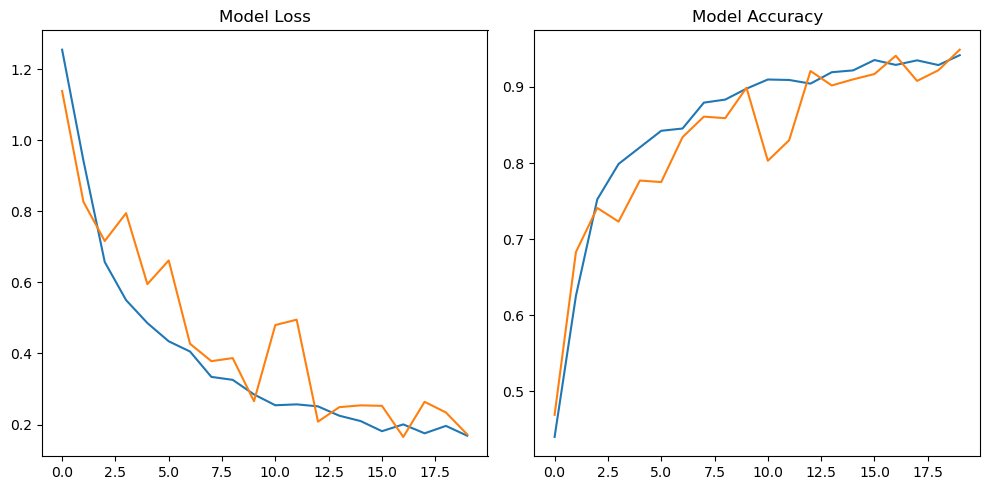

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history['train_loss'])
ax1.plot(history['test_loss'])
ax1.set_title('Model Loss')

ax2.plot(history['train_accuracy'])
ax2.plot(history['test_accuracy'])
ax2.set_title('Model Accuracy')

plt.tight_layout()
plt.show()